In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from SceneR2.core import *
from SceneR2.learners import ModelLearner, ParallelLearner
from SceneR2.dataset import CSVData, MovingObjectData, SingleCSV, MovingObjectData2
from SceneR2.dataset import *
from SceneR2.loss import weightedMSE
import pickle

In [3]:
! which python

/home/sufiyan/anaconda3/envs/fastai/bin/python


As loading and cleaning the dataset takes some time, we load the dataset and save it in a pickle file to be loaded below. This makes the process of loading the dataset quicker the next time we run the model.

In [45]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'wb') as f:
    pickle.dump(data, f)

/home/sufiyan/MTP/code/Notebooks/SceneR2/dataset.py:209: DtypeWarning: Columns (2376,2504) have mixed types. Specify dtype option on import or set low_memory=False.
  if preload: self.data = [SingleCSV.fromCSV(self.files[i], **self.kwargs).data for i in range(self.__len__())]


In [3]:
data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovingObject_160_csv_24Feb", 'wb') as f:
    pickle.dump(data, f)

Loading the dataset. To see how the dataset works, see [SceneR2/dataset.py](https://github.com/dumbPy/MTP/blob/master/SceneR2/dataset.py)

In [4]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_160_csv_14Feb", 'rb') as f:
    dataset=pickle.load(f)

In [14]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovingObject_160_csv_24Feb", 'rb') as f:
    dataset=pickle.load(f)

Total number of files in the dataset

In [15]:
len(dataset)

161

Number of files for **Left**, **Right** and **Other** classes respectively. These include flipped files for Left and Right

In [16]:
print(len([1 for x,y in dataset if y==0]))
print(len([1 for x,y in dataset if y==1]))
print(len([1 for x,y in dataset if y==2]))

61
62
38


In [17]:
dataset.play(20)

Seperating train and test files.

In [18]:
np.random.seed(10) #seting seed for always selecting same train and test set
totalFiles=len(dataset)
testFiles=np.random.choice(totalFiles, int(0.2*totalFiles)) #20% files as test files

Defining the Dataloaders for training and validation data

In [19]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(dataset) if i in testFiles])

A simple model defined below is trained. It consists of a 2 Layer LSTM followed by a fully connected Layer

In [10]:
class CSVmodel(nn.Module):
    def __init__(self,categories=3, input_size=5, hidden_size=10, dropout=0.1):
        super().__init__()
        self.l1=nn.LSTM(input_size=input_size,hidden_size=hidden_size, dropout=dropout, num_layers=2)
        self.l2=nn.Linear(in_features=hidden_size,out_features=categories)
        self.softmax=nn.Softmax()
    def forward(self,x):
        x,_=self.l1(x)
        x=x[:,-1,:]
        x= self.l2(x)
        return x

ParallelLearner class takes ModelLearners that take models and other parameters like learning rate, optimization function and loss function.

In [11]:
learner=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,0.1]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [0.5,0.5,0.1]), 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.MSELoss, optim=torch.optim.SGD, 
                             modelName='movingObjectDataModel' ),
                ModelLearner(CSVmodel(), lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='movingObjectDataModel' )],
        epochs=10, trainLoader=trainLoader, validLoader=testLoader)

The ParallelLearner trains all the models parallelly by using the same data

In [12]:
learner.train(300)

Plotting the loss for all the 4 models above. 

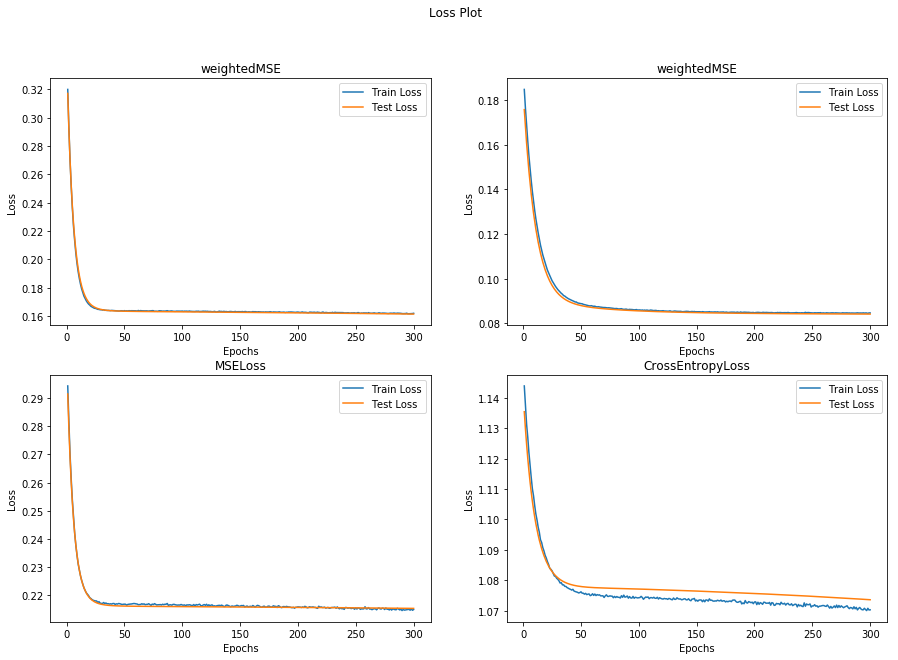

In [13]:
learner.plotLoss(figsize=(15,10))

Plotting confusion matrix for training dataset for all the four loss functions namely weighted_MSE (1,1,0.1), weighted_MSE(0.5, 0.5, 0.1), MSE and CrossEntropyLoss.

In [14]:
print("wMSE1"); print(learner.learners[0].train_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].train_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].train_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].train_confusion_matrix_list[-1])

wMSE1
[[42  9  0]
 [20 30  0]
 [27  4  0]]
wMSE2
[[38 13  0]
 [35 15  0]
 [19 12  0]]
MSE
[[39 12  0]
 [31 19  0]
 [26  5  0]]
CE
[[48  3  0]
 [49  1  0]
 [27  4  0]]


In [15]:
learner.learners[2].loss

MSELoss()

Confision Matrix for all the loss functions for test data

In [16]:
print("wMSE1"); print(learner.learners[0].valid_confusion_matrix_list[-1])
print("wMSE2"); print(learner.learners[1].valid_confusion_matrix_list[-1])
print("MSE"); print(learner.learners[2].valid_confusion_matrix_list[-1])
print("CE"); print(learner.learners[3].valid_confusion_matrix_list[-1])

wMSE1
[[8 2 0]
 [3 9 0]
 [4 3 0]]
wMSE2
[[9 1 0]
 [6 6 0]
 [2 5 0]]
MSE
[[3 7 0]
 [3 9 0]
 [3 4 0]]
CE
[[10  0  0]
 [ 7  5  0]
 [ 4  3  0]]


We see above in test/validation data that the model does considerably well in MSE on **Left (0)** and **right (1)** classes, while it doesn't on **Other** classes (2). It doesn't perform well in weighted MSE class or Cross Entropy either. We will try to train the same model with weighted MSE with high weight to **Other (2)** class and see how it works below.

In [17]:
learner_2=ParallelLearner(
                [ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' ),
                 ModelLearner(CSVmodel(), lr=0.001, loss_fn=partial(weightedMSE, [1,1,10]), 
                              optim=torch.optim.SGD, modelName='movingObjectDataModel' )
                ],epochs=100, trainLoader=trainLoader, printEvery=102, validLoader=testLoader)

In [41]:
learner_2.learners[0].model.l1()

LSTM(5, 10, num_layers=2, dropout=0.1)

In [18]:
learner_2.train(100)

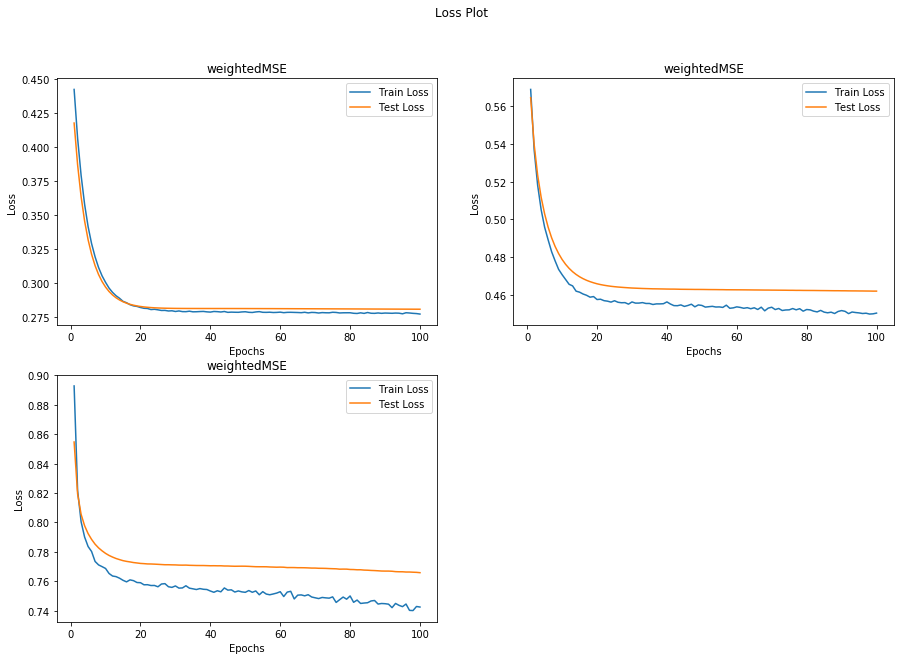

In [19]:
learner_2.plotLoss(figsize=(15,10))

In [20]:
print("wMSE_1:1:2"); print(learner_2.learners[0].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_2.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:10"); print(learner_2.learners[2].valid_confusion_matrix_list[-1])

wMSE_1:1:2
[[ 0 10  0]
 [ 6  6  0]
 [ 2  5  0]]
wMSE_1:1:5
[[9 1 0]
 [4 8 0]
 [5 2 0]]
wMSE_1:1:10
[[7 3 0]
 [3 9 0]
 [1 6 0]]


We see that, as we increase the weight for **Other (2)** class to 10, the model does tries to learn the class, but messes the other 2 classes. Other  than that, the model is not able to learn the **Other** class.

The above models were trained only with considering 4 columns representing MovingObjects as below

In [21]:
mov_data=MovingObjectData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/", preload=False)

/home/sufiyan/MTP/code/Notebooks/SceneR2/dataset.py:233: UserWarning: preload=False will load first 100 CSVs to calculate mean and std for standardScalar
  warnings.warn("preload=False will load first 100 CSVs to calculate mean and std for standardScalar")


AttributeError: 'tuple' object has no attribute 'full_df'

Reason for Braking:  Pedestrian A


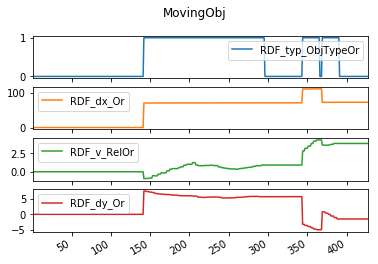

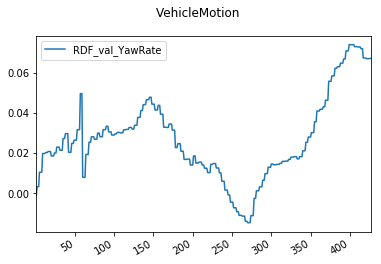

In [22]:
mov_data.plot(1)

As we see here, in the above plot, the model was trained on moving object data where as the ABA had reacted to a Pedestrian's presence and the moving object data is highly non-conclusive as to where the moving object is moving, if at all there is a moving object. Hence we will now try to train the model considering all 12 columns (4 corrosponding to ABA's reaction, Moving Object, Stationary object and Pedestrian each)

In [23]:
full_data=CSVData.fromCSVFolder("/home/sufiyan/data/Daimler/100_vids/csv/")
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_20Feb", 'wb') as f:
    pickle.dump(full_data, f)

In [24]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_CSVData_160_csv_20Feb", 'rb') as f:
    full_data=pickle.load(f)

Reason for Braking:  Driving/Moving Object


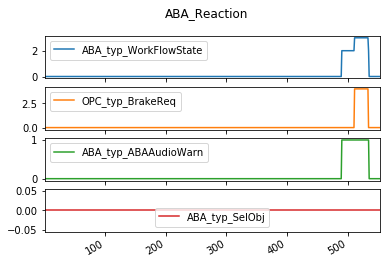

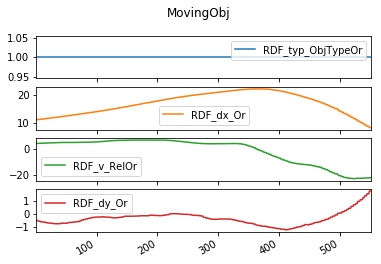

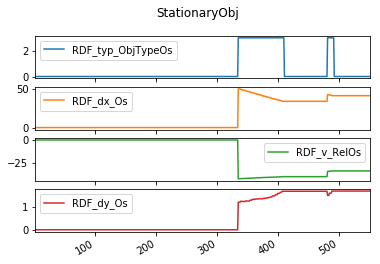

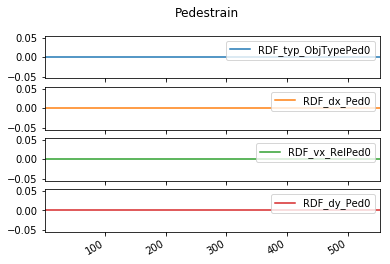

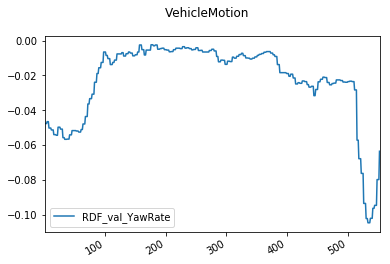

In [25]:
full_data.plot(0)

When we use the full data i.e., [SceneR2/dataset.CSVData](https://github.com/dumbPy/MTP/blob/3d9ca8ab8b395ae1592e49f38cc503bb5fafedf4/SceneR2/dataset.py#L203), we see that for the same file, we get all the columns and we hope the simple model defined above might be able to detect **Other (2)** class better.

Let's try to train the model with full  data and see how the model reacts to it

In [26]:
trainLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if not i in testFiles])
testLoader=torch.utils.data.DataLoader([(x,y) for i,(x,y) in enumerate(full_data) if i in testFiles])

In [27]:
learner_3=ParallelLearner([
                ModelLearner(CSVmodel(input_size=17, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.MSELoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_1' ),
                ModelLearner(CSVmodel(input_size=17, hidden_size=20), 
                             lr=0.001, loss_fn=torch.nn.CrossEntropyLoss, 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_2' ),
                ModelLearner(CSVmodel(input_size=17, hidden_size=20), 
                              lr=0.001, loss_fn=partial(weightedMSE, [1,1,2]), 
                              optim=torch.optim.SGD, modelName='CSVModel_full_data_3' ),
                ModelLearner(CSVmodel(input_size=17, hidden_size=20), 
                             lr=0.001, loss_fn=partial(weightedMSE, [1,1,5]), 
                             optim=torch.optim.SGD, modelName='CSVModel_full_data_4' )],
        epochs=100, trainLoader=trainLoader, validLoader=testLoader)

In [28]:
learner_3.train(epochs=300)

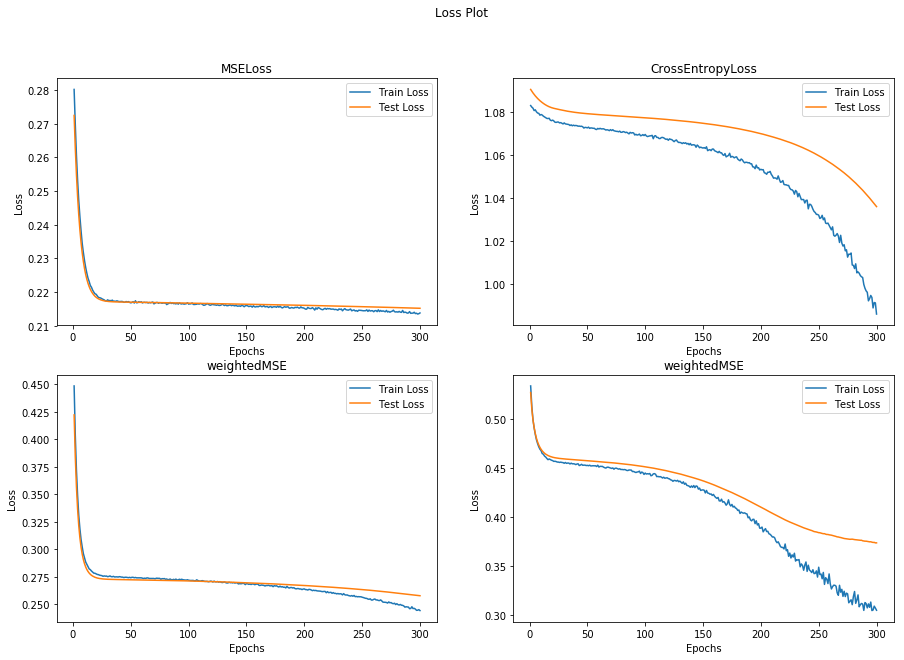

In [29]:
learner_3.plotLoss(figsize=(15,10))

Plotting Confusion Matrix on train data

In [30]:
print("MSE"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].train_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].train_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].train_confusion_matrix_list[-1])

MSE
[[42  9  0]
 [30 20  0]
 [22  9  0]]
CE
[[42  9  0]
 [ 9 41  0]
 [27  4  0]]
wMSE_1:1:2
[[40 10  1]
 [11 39  0]
 [30  1  0]]
wMSE_1:1:5
[[22 20  9]
 [ 2 45  3]
 [ 6  0 25]]


Plotting Confusion Matrix on validation/test data

In [31]:
print("MSE"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])
print("CE"); print(learner_3.learners[1].valid_confusion_matrix_list[-1])
print("wMSE_1:1:2"); print(learner_3.learners[2].valid_confusion_matrix_list[-1])
print("wMSE_1:1:5"); print(learner_3.learners[3].valid_confusion_matrix_list[-1])

MSE
[[ 8  2  0]
 [ 2 10  0]
 [ 2  5  0]]
CE
[[8 2 0]
 [5 7 0]
 [5 2 0]]
wMSE_1:1:2
[[8 2 0]
 [6 6 0]
 [6 1 0]]
wMSE_1:1:5
[[5 5 0]
 [2 6 4]
 [1 1 5]]


As model with **weighted MSE loss \[1,1,2 \]** seems  to be performing better than rest, we will try training that model further and see how it performs.

We remove all other models from ParallelLearner and train the **weightedMSE** model further

#### The model output after training with full 16 columns is still non-conclusive.

In [32]:
allModelLearners=learner_3.learners[:]
learner_3.learners=[learner_3.learners[3]]

Training for 100 more epochs (total epochs=400)

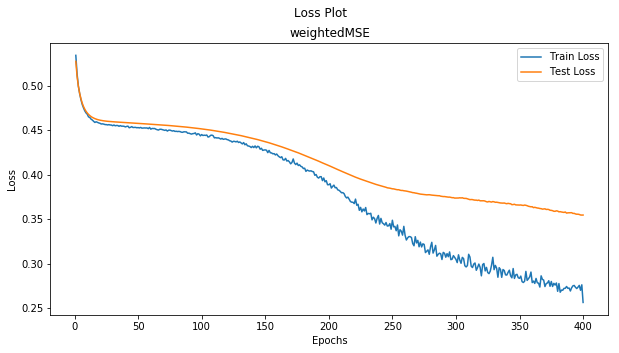

In [33]:
learner_3.train(100)
learner_3.plotLoss(figsize=(10,5))

In [34]:
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])

wMSE_1:1:2  Train 

[[ 9 33  9]
 [ 2 45  3]
 [ 3  0 28]]
wMSE_1:1:2  Validation 

[[5 5 0]
 [0 8 4]
 [0 1 6]]


Training for 100 more epochs (total epochs=500)

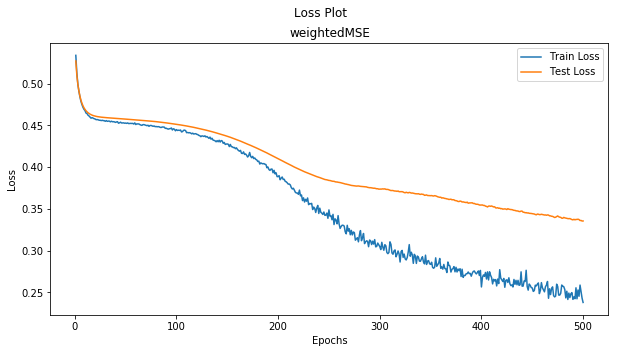

wMSE_1:1:2  Train 

[[14 30  7]
 [ 1 46  3]
 [ 2  0 29]]
wMSE_1:1:2  Validation 

[[4 6 0]
 [0 8 4]
 [0 1 6]]


In [35]:
learner_3.train(100)
learner_3.plotLoss(figsize=(10,5))
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])

Training for 100 more epochs (total epochs=800)

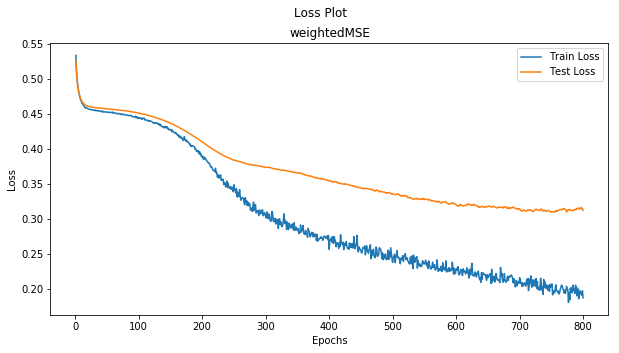

wMSE_1:1:2  Train 

[[27 18  6]
 [ 5 44  1]
 [ 1  0 30]]
wMSE_1:1:2  Validation 

[[9 1 0]
 [1 8 3]
 [1 1 5]]


In [36]:
learner_3.train(300)
learner_3.plotLoss(figsize=(10,5))
print("wMSE_1:1:2  Train \n"); print(learner_3.learners[0].train_confusion_matrix_list[-1])
print("wMSE_1:1:2  Validation \n"); print(learner_3.learners[0].valid_confusion_matrix_list[-1])



The model seems to overfit after a certain epochs. The accuracy over Class 0 improved on train data but not on test data

In [2]:
dataset_4=MovingObjectData2.fromCSVFolder(globalVariables.path_to_csv, skip_labels=[1,2])

In [3]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovingObject2_157_NewEdgeDetection_25Feb", 'wb') as f:
    pickle.dump(dataset_4, f)

In [72]:
dataset_all = CSVData.fromCSVFolder(globalVariables.path_to_csv, skip_labels=[1,2])
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_CSVData_157_NewEdgeDetection_25Feb", 'wb') as f:
    pickle.dump(dataset_all, f)

[(574, 62.61715999999999), (575, 62.61716), (604, 14.125), (605, 14.125), (771, 21.41410000000002), (772, 21.41409999999999)]
Edge_0:  [898]
Edge_1:  [574, 575, 604, 605, 771, 772]
[(0, 377.77299999999997), (1, 377.77299999999997), (79, 36.99250000000001), (80, 36.99250000000001), (577, 93.42929999999998), (578, 93.42930000000001)]
Edge_0:  []
Edge_1:  [577, 578]
[(532, 0.4609400000000008), (533, 0.4609400000000008), (603, 92.70347), (604, 92.70347), (662, 4.350999999999999), (663, 4.350999999999999)]
Edge_0:  [682]
Edge_1:  [532, 533, 603, 604, 662, 663]
[(579, 34.2031), (580, 34.203100000000006), (857, 34.13279999999999), (858, 34.1328), (934, 42.27350000000001), (935, 42.2735)]
Edge_0:  [990]
Edge_1:  [579, 580, 857, 858, 934, 935]
[(551, 0.46875), (552, 0.46875), (569, 80.47655999999999), (570, 80.47656), (903, 8.1798), (904, 8.1798)]
Edge_0:  [678]
Edge_1:  [551, 552, 569, 570, 903, 904]
[(526, 0.5391000000000012), (528, 0.5391000000000012), (536, 0.5625), (537, 0.5625), (543, 0.5

[(163, 19.679699999999997), (164, 19.679699999999997), (584, 51.203140000000005), (585, 51.203140000000005), (755, 1.242200000000011), (756, 1.2421999999999969)]
Edge_0:  [998]
Edge_1:  [584, 585, 755, 756]
[(479, 0.8280999999999992), (480, 0.8280999999999992), (562, 0.59375), (563, 0.59375), (614, 73.25783), (615, 73.25783)]
Edge_0:  [567]
Edge_1:  [479, 480, 562, 563, 614, 615]
[(499, 0.1875), (500, 0.1875), (502, 0.1875), (503, 0.1875), (506, 0.1875), (507, 0.1875)]
Edge_0:  [620]
Edge_1:  [499, 500, 502, 503, 506, 507]
[(70, 8.25), (71, 8.25), (766, 90.85154000000001), (767, 90.85154), (982, 9.382000000000005), (983, 9.382000000000005)]
Edge_0:  [906]
Edge_1:  [766, 767, 982, 983]
[(202, 2.492199999999997), (203, 2.492199999999997), (278, 8.343799999999995), (279, 8.343800000000002), (887, 39.19529), (888, 39.19529)]
Edge_0:  [998]
Edge_1:  [887, 888]
[(558, 0.6405999999999992), (559, 0.6405999999999992), (561, 0.6483999999999988), (562, 0.6484000000000023), (569, 68.65629999999999

[(543, 0.4765599999999992), (547, 0.5), (548, 0.5000000000000018), (554, 0.476560000000001), (555, 0.476560000000001), (566, 0.476560000000001)]
Edge_0:  [573]
Edge_1:  [543, 547, 548, 554, 555, 566]
[(502, 0.6328000000000031), (503, 0.632799999999996), (517, 1.2656999999999954), (518, 1.2657000000000025), (557, 0.6327999999999996), (558, 0.6327999999999996)]
Edge_0:  [998]
Edge_1:  [502, 503, 517, 518, 557, 558]
[(190, 1.125), (191, 1.125), (209, 0.5938000000000017), (210, 0.5937999999999946), (212, 0.5859000000000023), (213, 0.5858999999999988)]
Edge_0:  [221]
Edge_1:  [190, 191, 209, 210, 212, 213]
[(525, 50.29690000000001), (526, 50.296899999999994), (558, 26.39070000000001), (559, 26.390699999999995), (710, 36.8438), (711, 36.84379999999999)]
Edge_0:  [767]
Edge_1:  [525, 526, 558, 559, 710, 711]
[(503, 0.375), (504, 0.375), (506, 0.375), (507, 0.375), (561, 0.40625), (562, 0.4062500000000018)]
Edge_0:  [998]
Edge_1:  [503, 504, 506, 507, 561, 562]
[(289, 25.578099999999992), (290

[(0, 305.828), (1, 305.82800000000003), (809, 87.83590999999998), (810, 87.83591), (933, 2.843699999999984), (934, 2.8437000000000126)]
Edge_0:  [956]
Edge_1:  [809, 810, 933, 934]
[(553, 1.67971), (554, 1.67971), (600, 70.17187), (601, 70.17187), (661, 2.414100000000019), (662, 2.4140999999999906)]
Edge_0:  [619]
Edge_1:  [553, 554, 600, 601, 661, 662]
[(541, 0.4609400000000008), (544, 0.46875), (545, 0.46875), (556, 0.460939999999999), (562, 38.03129), (563, 38.031290000000006)]
Edge_0:  [999]
Edge_1:  [541, 544, 545, 556, 562, 563]
[(473, 1.25), (474, 1.25), (535, 0.8516000000000048), (536, 0.8515999999999977), (546, 0.867200000000004), (547, 0.8671999999999969)]
Edge_0:  [551]
Edge_1:  [473, 474, 535, 536, 546, 547]
[(503, 0.28906000000000276), (504, 0.2890599999999992), (511, 0.2968800000000016), (512, 0.2968800000000016), (950, 120.35166), (951, 120.35166000000001)]
Edge_0:  [560]
Edge_1:  [503, 504, 511, 512, 950, 951]
[(533, 1.0), (534, 1.0), (595, 56.4063), (596, 56.4062999999

PicklingError: Can't pickle <class 'SceneR2.dataset.CSVData'>: it's not the same object as SceneR2.dataset.CSVData

In [3]:
with open("/home/sufiyan/data/Daimler/100_vids/pickled_SceneR2_dataset/pickled_MovingObject2_157_NewEdgeDetection_25Feb", 'rb') as f:
    dataset_4=pickle.load(f)

In [19]:
d=SingleCSV.fromCSV(dataset_4.files[1])

In [8]:
name=dataset_4.files[1]

In [5]:
print(len([1 for x,y in dataset_4 if y==0]))
print(len([1 for x,y in dataset_4 if y==1]))
print(len([1 for x,y in dataset_4 if y==2]))

61
62
34


In [15]:
len(dataset_4)

157

In [11]:
dataset_4.play(1)

In [22]:
df=read_csv_auto(dataset_4.files[1])

In [23]:
SingleCSV.getEdgePostABA(df, 0)

470

In [ ]:
plt.plot()

In [54]:
dataset_4.play(6)

[(648, 1), (649, 1), (721, 1), (722, 1), (800, 1), (801, 1)]
[(528, 0.6171999999999969), (529, 0.617200000000004), (535, 0.6328000000000031), (536, 0.632799999999996), (553, 0.6172000000000004), (554, 0.6172000000000004)]
Edge_0:  [648, 649, 721, 722, 800, 801]
Edge_1:  [528, 529, 535, 536, 553, 554]


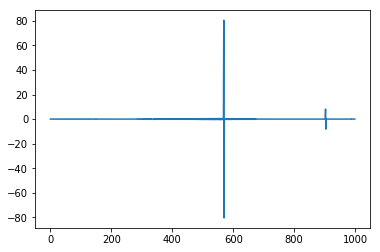

In [4]:
plt.plot(laplace(read_csv_auto(dataset_4.files[4])["RDF_dx_Or"]))

Files with problem
17
18 - Night Time, Video over exposed


In [63]:
dataset_4.files[33]

'/home/sufiyan/data/Daimler/100_vids/csv/20170421_235710_S235_500K_V173015_HW_DML.csv'

In [36]:
dataset_4.play(20)

[602]
ABAReactionIndex:  518
Edge_0:  [602]
Edge_1:  [872]


In [66]:
dataset_4.play(34)

[547]
ABAReactionIndex:  473
Edge_0:  [547]
Edge_1:  [600]


[593]
ABAReactionIndex:  500
Edge_0:  [593]
Edge_1:  [726]
Reason for Braking:  Driving/Moving Object
Label:  0
edgePostABA:  592


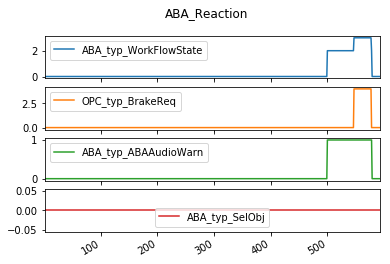

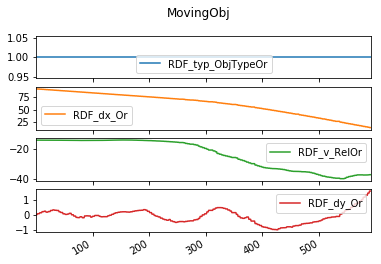

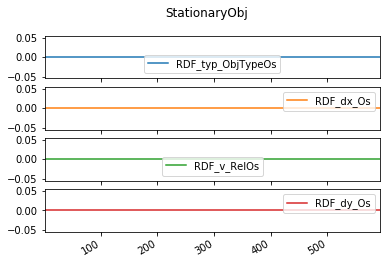

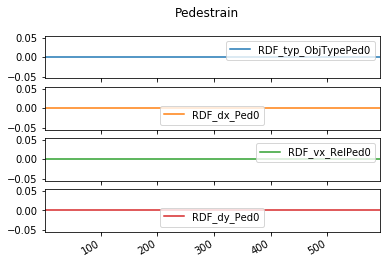

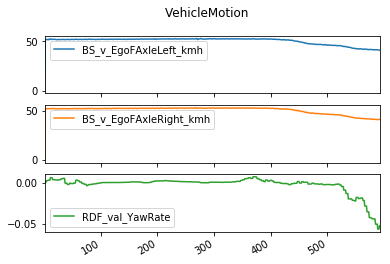

In [71]:
dataset_4.plot(37, all_columns=True, supressPostABA=True)

In [30]:
d=SingleCSV(read_csv_auto(name), name)

In [24]:
mv=MovingObject(read_csv_auto(name))

In [25]:
mv.getEdgePostABA(1)

469

Reason for Braking:  Driving/Moving Object


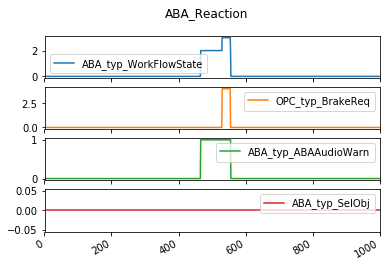

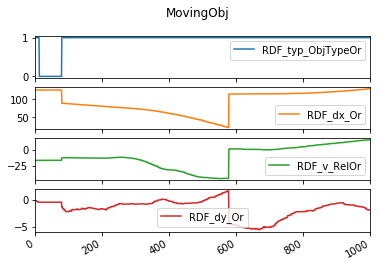

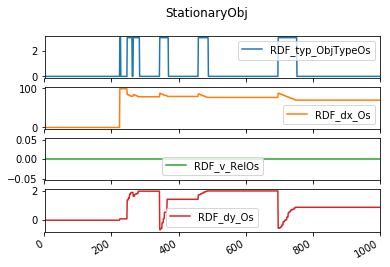

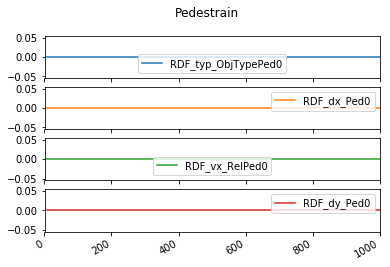

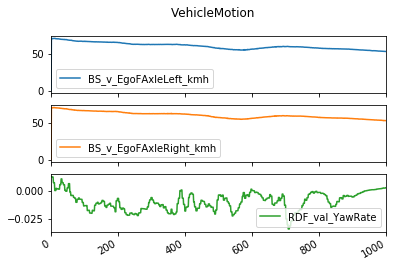

In [32]:
d.plot()